# Improvement 1

## Turkish Wild Fires data (Same As baseline)


In [1]:
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/hgctmx9y6c-1.zip


--2025-05-05 22:23:26--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/hgctmx9y6c-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 3.5.72.20, 52.92.16.162, 52.218.61.64, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|3.5.72.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2418588752 (2.3G) [application/zip]
Saving to: ‘hgctmx9y6c-1.zip’

hgctmx9y6c-1.zip    100%[===================>]   2.25G  18.0MB/s    in 2m 5s   

2025-05-05 22:25:32 (18.4 MB/s) - ‘hgctmx9y6c-1.zip’ saved [2418588752/2418588752]



In [2]:
!unzip hgctmx9y6c-1.zip


Archive:  hgctmx9y6c-1.zip
  inflating: Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/Dataset.rar  


In [3]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [4]:
!unrar x "Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/Dataset.rar" \
         "Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/"


Streaming output truncated to the last 5000 lines.
Extracting  Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/Dataset/Train Masks/Image (55).tif      99%  OK 
Extracting  Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/Dataset/Train Masks/Image (550).tif      99%  OK 
Extracting  Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/Dataset/Train Masks/Image (5500).tif      99%  OK 
Extracting  Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/Dataset/Train Masks/Image (5501).tif      99%  OK 
Extracting  Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/Dataset/Train Masks/Image (5502).tif      99%  OK 
Extracting  Deep Learning and Remote Sensi

In [5]:
!pip install rasterio --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 111.5 MB/s eta 0:00:00


Visualizing Dataset (same as Baseline)

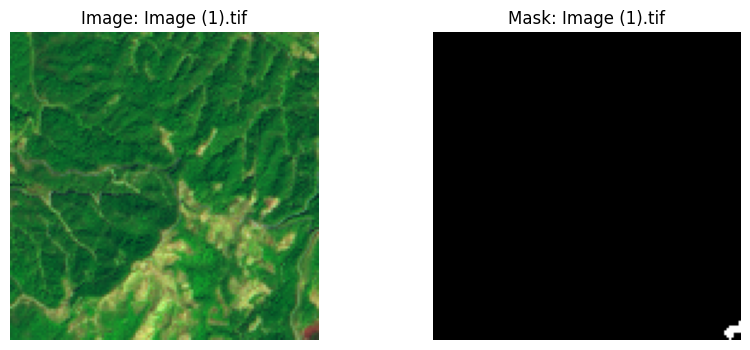

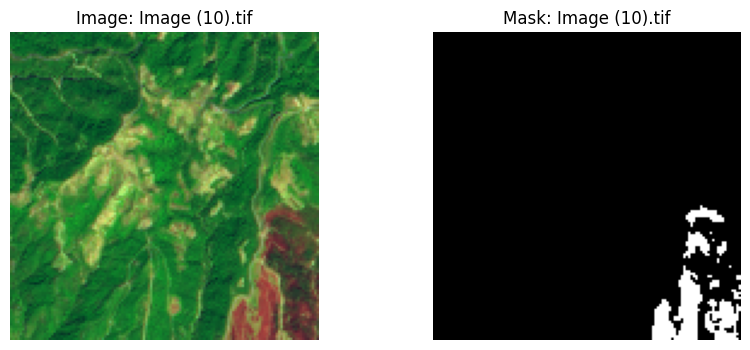

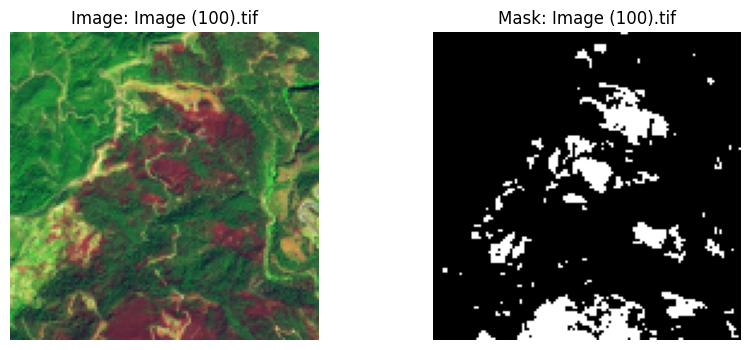

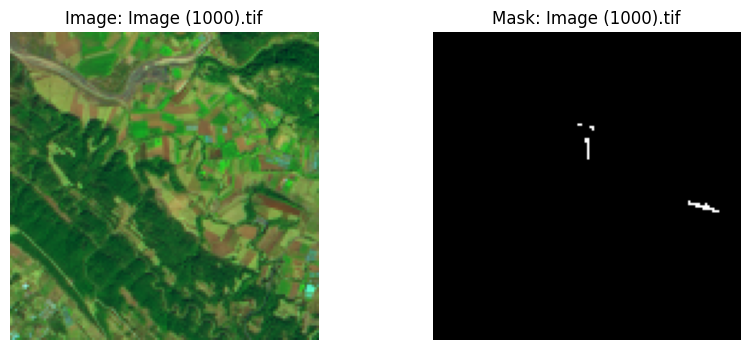

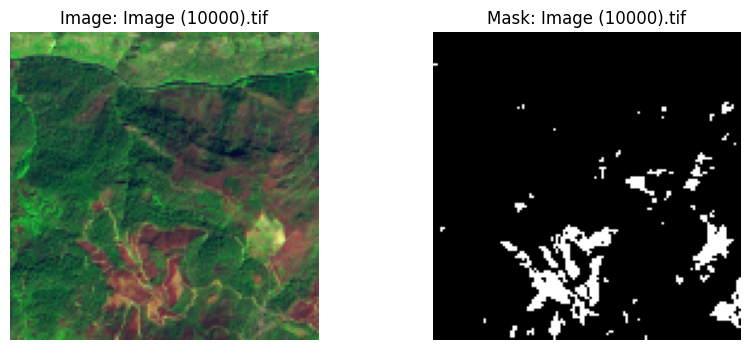

In [11]:
import os
import matplotlib.pyplot as plt
import rasterio
import numpy as np

image_dir = "Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/Dataset/Train Images"
mask_dir = "Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/Dataset/Train Masks"

image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

for i in range(5):
    image_path = os.path.join(image_dir, image_files[i])
    mask_path = os.path.join(mask_dir, mask_files[i])

    with rasterio.open(image_path) as src:
        image = src.read([1, 2, 3]) if src.count >= 3 else np.stack([src.read(1)] * 3)
        image = np.transpose(image, (1, 2, 0))
        image = (image - image.min()) / (image.max() - image.min() + 1e-6)

    with rasterio.open(mask_path) as src:
        mask = src.read(1)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {image_files[i]}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Mask: {mask_files[i]}")
    plt.axis("off")

    plt.show()


In [13]:
import os
import random
import re
from tqdm import tqdm

import numpy as np
import rasterio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as TF

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Dataloading (Same as Baseline)

In [14]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

class WildfireDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_filenames, mask_filenames, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.transform = transform

        for img_f, msk_f in zip(self.image_filenames, self.mask_filenames):
             if natural_sort_key(img_f) != natural_sort_key(msk_f):
                 print(f"Warning: Mismatch detected or sorting error? {img_f} vs {msk_f}")

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_name = os.path.join(self.mask_dir, self.mask_filenames[idx])

        try:
            with rasterio.open(img_name) as src:
                if src.count >= 3:
                    image = src.read([1, 2, 3]).astype(np.float32)
                else:
                    img_data = src.read(1).astype(np.float32)
                    image = np.stack([img_data] * 3, axis=0)

                min_val = image.min()
                max_val = image.max()
                if max_val - min_val > 1e-6:
                    image = (image - min_val) / (max_val - min_val)
                else:
                    image = image - min_val

            with rasterio.open(mask_name) as src:
                mask = src.read(1).astype(np.float32)
                mask = np.expand_dims(mask, axis=0)

            image_tensor = torch.from_numpy(image)
            mask_tensor = torch.from_numpy(mask)

            if self.transform:
                pass

            return image_tensor, mask_tensor

        except Exception as e:
            print(f"Error loading sample {idx}: {img_name} / {mask_name}")
            print(f"Error message: {e}")
            raise e


base_dir = "Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/Dataset"
image_dir = os.path.join(base_dir, "Train Images")
mask_dir = os.path.join(base_dir, "Train Masks")

all_image_files = sorted(os.listdir(image_dir), key=natural_sort_key)
all_mask_files = sorted(os.listdir(mask_dir), key=natural_sort_key)

if len(all_image_files) != len(all_mask_files):
    print("Error: Mismatch in number of image and mask files!")
else:
    mismatched = False
    for i, (img_f, msk_f) in enumerate(zip(all_image_files, all_mask_files)):
        img_num = re.search(r'\((\d+)\)', img_f)
        msk_num = re.search(r'\((\d+)\)', msk_f)
        if not img_num or not msk_num or img_num.group(1) != msk_num.group(1):
            print(f"Mismatch found at index {i}: {img_f} vs {msk_f}")
            mismatched = True
    if not mismatched:
        print("Image and Mask filenames seem to correspond correctly after sorting.")


indices = list(range(len(all_image_files)))
train_indices, test_indices = train_test_split(indices, test_size=0.3, random_state=42) # 70/30 split

train_image_files = [all_image_files[i] for i in train_indices]
train_mask_files = [all_mask_files[i] for i in train_indices]
test_image_files = [all_image_files[i] for i in test_indices]
test_mask_files = [all_mask_files[i] for i in test_indices]

print(f"Total samples: {len(all_image_files)}")
print(f"Training samples: {len(train_image_files)}")
print(f"Test samples: {len(test_image_files)}")


train_dataset = WildfireDataset(image_dir, mask_dir, train_image_files, train_mask_files)
test_dataset = WildfireDataset(image_dir, mask_dir, test_image_files, test_mask_files)

BATCH_SIZE = 32

def collate_fn_skip_error(batch):
    batch = list(filter(lambda x: x is not None, batch))
    if not batch: return None, None
    return torch.utils.data.dataloader.default_collate(batch)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("\nTesting DataLoader...")
try:
    images, masks = next(iter(train_loader))
    print("Batch loaded successfully:")
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)
    print("Image dtype:", images.dtype)
    print("Mask dtype:", masks.dtype)
    print("Image min/max:", images.min().item(), images.max().item())
    print("Mask min/max:", masks.min().item(), masks.max().item())
except Exception as e:
    print(f"Error testing DataLoader: {e}")
    print("There might be an issue with file loading or processing in the Dataset class.")

Image and Mask filenames seem to correspond correctly after sorting.
Total samples: 25563
Training samples: 17894
Test samples: 7669

Testing DataLoader...
Batch loaded successfully:
Image batch shape: torch.Size([32, 3, 128, 128])
Mask batch shape: torch.Size([32, 1, 128, 128])
Image dtype: torch.float32
Mask dtype: torch.float32
Image min/max: 0.0 1.0
Mask min/max: 0.0 1.0


Lightweight Architecture

In [15]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

import torch.nn.functional as F

class LightweightUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True, base_c=16):
        super(LightweightUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, base_c)
        self.down1 = Down(base_c, base_c * 2)
        self.down2 = Down(base_c * 2, base_c * 4)
        self.down3 = Down(base_c * 4, base_c * 8)
        factor = 2 if bilinear else 1
        self.down4 = Down(base_c * 8, base_c * 16 // factor)
        self.up1 = Up(base_c * 16, base_c * 8 // factor, bilinear)
        self.up2 = Up(base_c * 8, base_c * 4 // factor, bilinear)
        self.up3 = Up(base_c * 4, base_c * 2 // factor, bilinear)
        self.up4 = Up(base_c * 2, base_c, bilinear)
        self.outc = OutConv(base_c, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

model = LightweightUNet(n_channels=3, n_classes=1).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'\nThe model has {count_parameters(model):,} trainable parameters')
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


The model has 1,080,929 trainable parameters


In [16]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0.0
    progress_bar = tqdm(loader, desc="Training", leave=False)
    for images, masks in progress_bar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    return epoch_loss / len(loader)



def compute_iou(preds, targets):
    smooth = 1e-6
    preds = preds.bool()
    targets = targets.bool()
    intersection = (preds & targets).float().sum()
    union = (preds | targets).float().sum()
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

def evaluate(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0.0
    total_pixels = 0
    correct_pixels = 0
    total_iou = 0.0
    num_batches = 0

    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Evaluating", leave=False)
        for images, masks in progress_bar:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            epoch_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            correct_pixels += (preds == masks.bool()).sum().item()
            total_pixels += masks.numel()
            total_iou += compute_iou(preds, masks)
            num_batches += 1

    avg_loss = epoch_loss / len(loader)
    accuracy = 100.0 * correct_pixels / total_pixels if total_pixels > 0 else 0.0
    avg_iou = total_iou / num_batches if num_batches > 0 else 0.0
    return avg_loss, accuracy, avg_iou


Starting Training...


Epoch 1/10: 	Train Loss: 0.4577 	Test Loss: 0.3946 	Test Accuracy: 96.52% 	IoU: 0.7990


Epoch 2/10: 	Train Loss: 0.3607 	Test Loss: 0.3229 	Test Accuracy: 97.07% 	IoU: 0.8300


Epoch 3/10: 	Train Loss: 0.2915 	Test Loss: 0.2518 	Test Accuracy: 97.68% 	IoU: 0.8598


Epoch 4/10: 	Train Loss: 0.2327 	Test Loss: 0.2044 	Test Accuracy: 98.04% 	IoU: 0.8728


Epoch 5/10: 	Train Loss: 0.1879 	Test Loss: 0.1696 	Test Accuracy: 97.96% 	IoU: 0.8661


Epoch 6/10: 	Train Loss: 0.1493 	Test Loss: 0.1416 	Test Accuracy: 98.07% 	IoU: 0.8829


Epoch 7/10: 	Train Loss: 0.1231 	Test Loss: 0.1058 	Test Accuracy: 98.50% 	IoU: 0.9041


Epoch 8/10: 	Train Loss: 0.1004 	Test Loss: 0.0901 	Test Accuracy: 98.46% 	IoU: 0.9024


Epoch 9/10: 	Train Loss: 0.0858 	Test Loss: 0.0753 	Test Accuracy: 98.36% 	IoU: 0.8936


Epoch 10/10: 	Train Loss: 0.0726 	Test Loss: 0.0636 	Test Accuracy: 98.58% 	IoU: 0.9094
Training Finished.


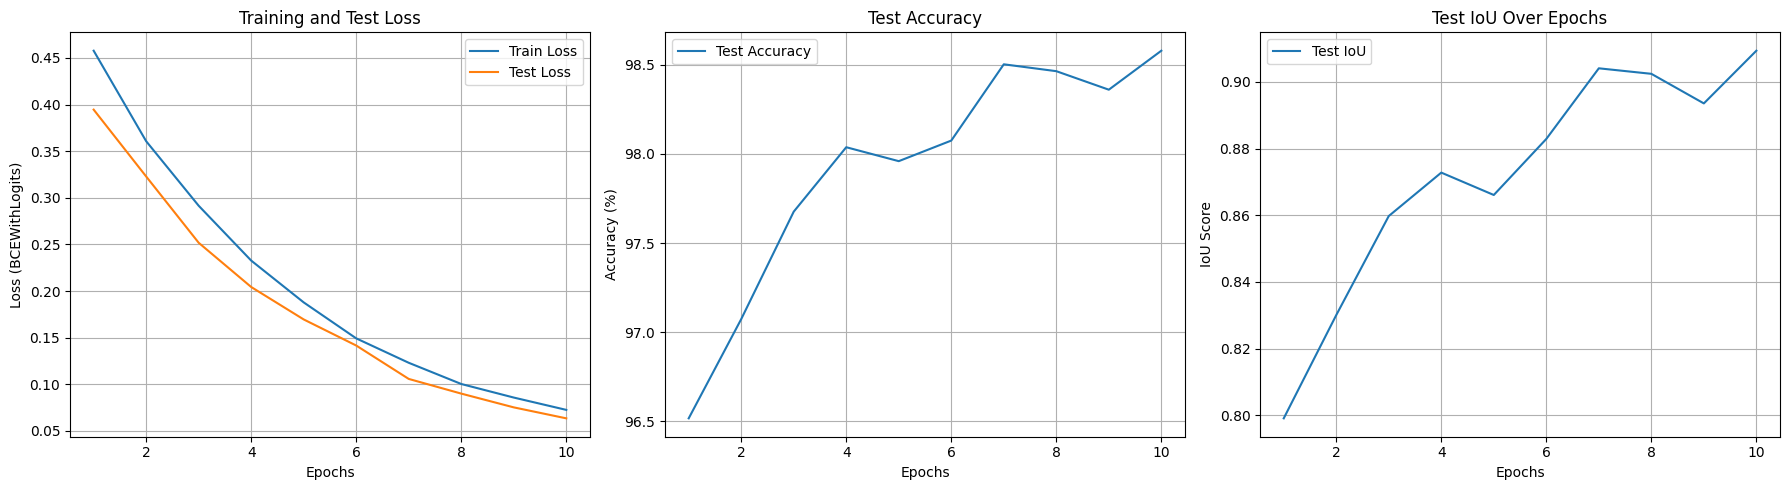

In [17]:
NUM_EPOCHS = 10

train_losses = []
test_losses = []
test_accuracies = []
test_ious = []

print("\nStarting Training...")
for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_accuracy, test_iou = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    test_ious.append(test_iou)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: \t"
          f"Train Loss: {train_loss:.4f} \t"
          f"Test Loss: {test_loss:.4f} \t"
          f"Test Accuracy: {test_accuracy:.2f}% \t"
          f"IoU: {test_iou:.4f}")

print("Training Finished.")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (BCEWithLogits)')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(range(1, NUM_EPOCHS + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(range(1, NUM_EPOCHS + 1), test_ious, label='Test IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.title('Test IoU Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



Visualizing Predictions on Test Set...


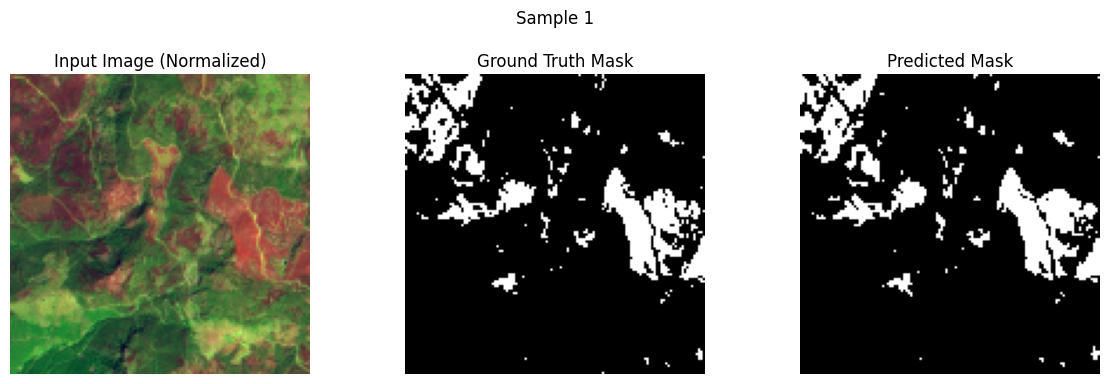

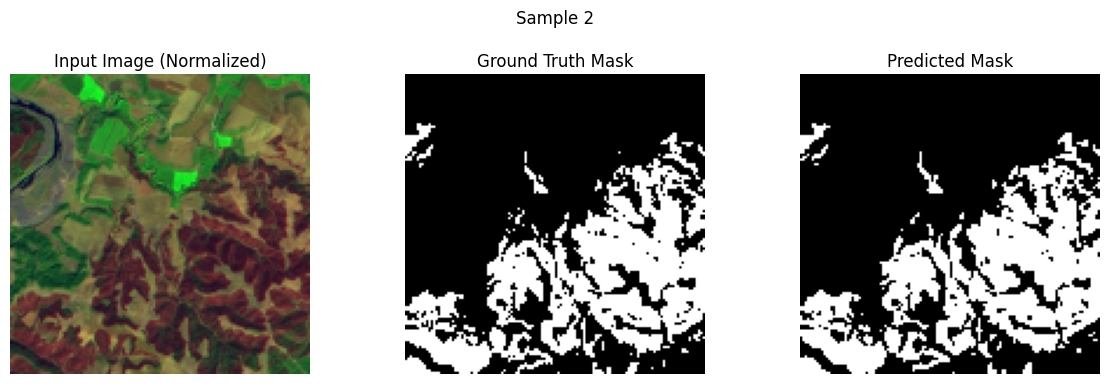

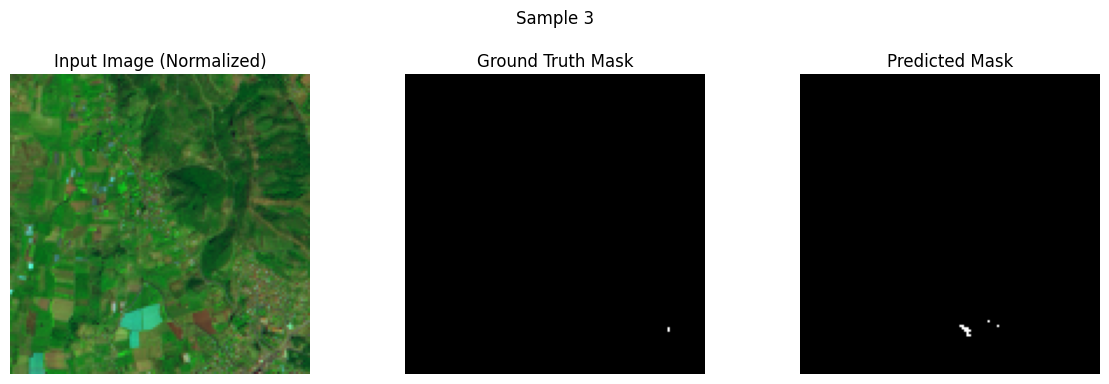

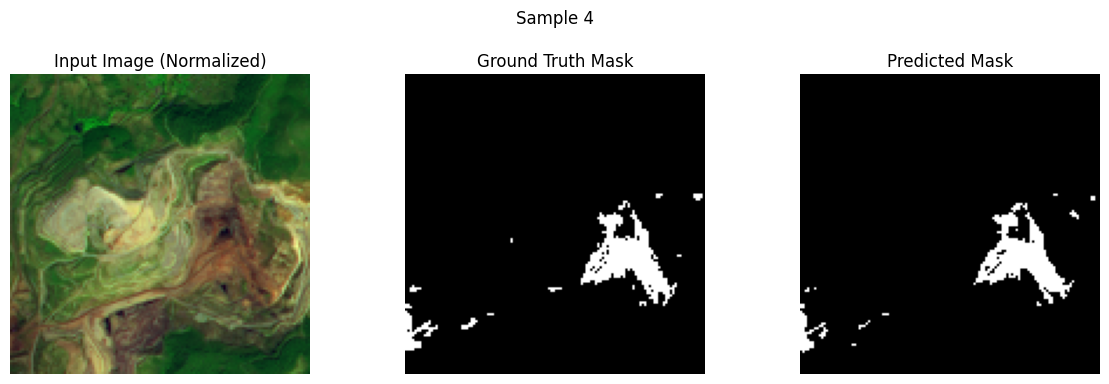

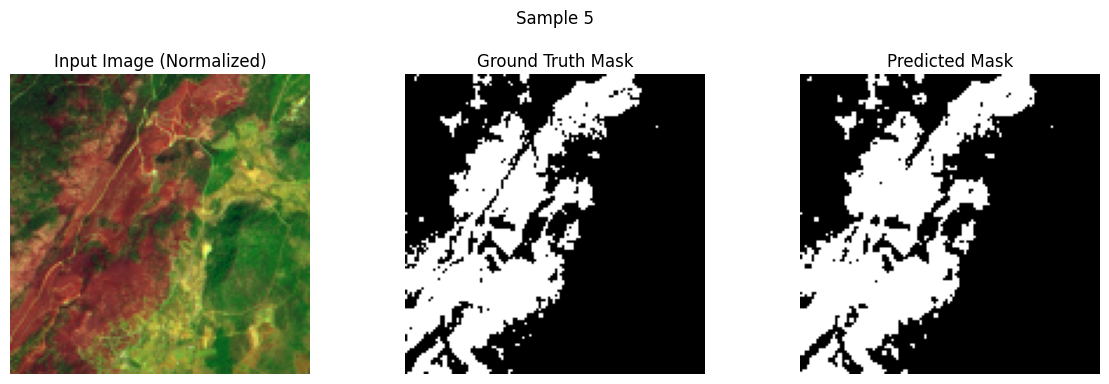


Final Test Loss: 0.0636
Final Test Accuracy: 98.58%
Final Test IoU Score: 0.9094
Model state_dict saved to wildfire_unet_model.pth


In [18]:
def visualize_predictions(model, loader, device, num_samples=5):
    model.eval()
    samples_shown = 0
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5

            images_np = images.cpu().numpy()
            masks_np = masks.cpu().numpy().squeeze(1)
            preds_np = preds.cpu().numpy().squeeze(1)

            for i in range(images_np.shape[0]):
                if samples_shown >= num_samples:
                    return

                image = np.transpose(images_np[i], (1, 2, 0))
                mask_true = masks_np[i]
                mask_pred = preds_np[i]


                image = np.clip(image, 0, 1)

                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.imshow(image)
                plt.title("Input Image (Normalized)")
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(mask_true, cmap='gray')
                plt.title("Ground Truth Mask")
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(mask_pred, cmap='gray')
                plt.title("Predicted Mask")
                plt.axis('off')

                plt.suptitle(f"Sample {samples_shown + 1}")
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()

                samples_shown += 1
            if samples_shown >= num_samples:
                break



print("\nVisualizing Predictions on Test Set...")
visualize_predictions(model, test_loader, device, num_samples=5)


final_test_loss, final_test_accuracy, IOU_score = evaluate(model, test_loader, criterion, device)
print(f"\nFinal Test Loss: {final_test_loss:.4f}")
print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")
print(f"Final Test IoU Score: {IOU_score:.4f}")


torch.save(model.state_dict(), 'wildfire_unet_model.pth')
print("Model state_dict saved to wildfire_unet_model.pth")

### Improvement 1: Replacing ResNetUNet with LightweightUNet

The original baseline model was a ResNetUNet, which used a pretrained ResNet-18 as its encoder. While powerful, this architecture resulted in **14,404,257 trainable parameters** and was relatively slow and resource-intensive.

To address this, I replaced it with a custom-built **LightweightUNet**. This model maintains the core U-Net architecture (encoder-decoder with skip connections) but removes the heavy ResNet backbone. Instead, it uses a streamlined encoder built from simple DoubleConv blocks and MaxPool layers, and a symmetric decoder using Up blocks with bilinear upsampling.

Key changes:
- Removed pretrained ResNet-18 encoder
- Introduced flexible base channel size (base_c = 16)
- All layers are trained from scratch for better task alignment

As a result, the model size was reduced from **14.4M → 1.08M parameters**, without a compromise on accuracy.
